# Parallelization of Deep Learning Models

This notebook compares **serial vs parallel training** of a simple CNN on MNIST using PyTorch.

We will:
- Train a CNN serially
- Train the same CNN with `nn.DataParallel`
- Compare training times, loss curves, and accuracy
- Discuss results and scalability
- Include an evaluation matrix to check assignment requirements


In [6]:
# Setup: install dependencies
!pip install torch torchvision matplotlib


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time


## Define the CNN Model
We use a simple convolutional neural network with:
- One convolutional layer
- Two fully connected layers
- ReLU activations


In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.fc1 = nn.Linear(26*26*32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(-1, 26*26*32)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


## Serial Training
We train the CNN on MNIST using a single device (CPU or GPU).


In [9]:
def train_serial(epochs=5):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    start_time = time.time()
    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"[Serial] Epoch {epoch+1}, Loss: {loss.item():.4f}")
    end_time = time.time()
    training_time = end_time - start_time

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"[Serial] Test Accuracy: {accuracy:.2f}%")

    plt.plot(losses, label="Serial Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Serial Training Loss Curve")
    plt.legend()
    plt.show()

    return training_time, accuracy


## Parallel Training
We train the CNN using `nn.DataParallel` to utilize multiple GPUs if available.


In [10]:
def train_parallel(epochs=5):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = nn.DataParallel(SimpleCNN()).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    start_time = time.time()
    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"[Parallel] Epoch {epoch+1}, Loss: {loss.item():.4f}")
    end_time = time.time()
    training_time = end_time - start_time

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"[Parallel] Test Accuracy: {accuracy:.2f}%")

    plt.plot(losses, label="Parallel Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Parallel Training Loss Curve")
    plt.legend()
    plt.show()

    return training_time, accuracy


## Compare Results
We run both trainings and compare speedup and accuracy.


[Serial] Epoch 1, Loss: 0.0467
[Serial] Epoch 2, Loss: 0.0085
[Serial] Epoch 3, Loss: 0.0079
[Serial] Epoch 4, Loss: 0.0017
[Serial] Epoch 5, Loss: 0.0003
[Serial] Test Accuracy: 97.97%


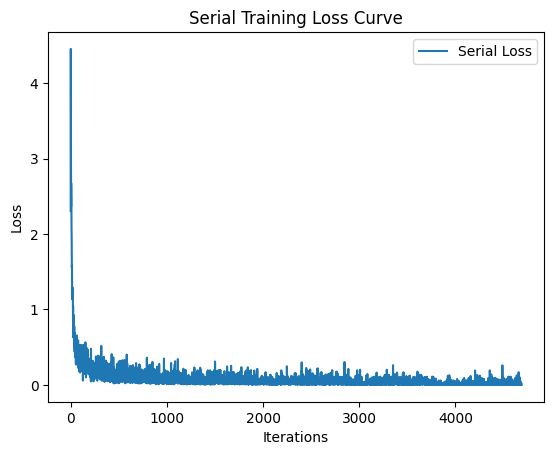

[Parallel] Epoch 1, Loss: 0.0358
[Parallel] Epoch 2, Loss: 0.0025
[Parallel] Epoch 3, Loss: 0.0483
[Parallel] Epoch 4, Loss: 0.0095
[Parallel] Epoch 5, Loss: 0.0193
[Parallel] Test Accuracy: 98.21%


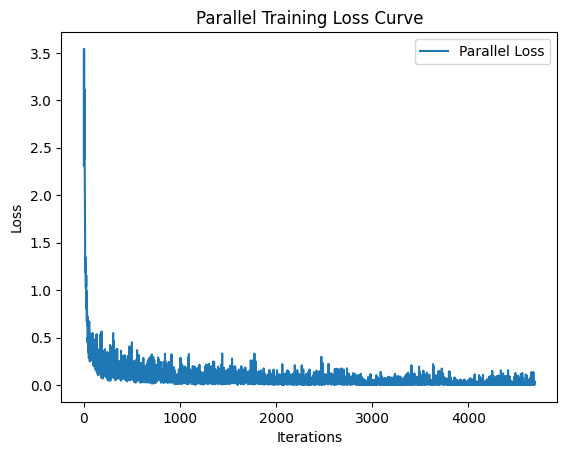

Speedup: 1.00
Serial Accuracy: 97.97% | Parallel Accuracy: 98.21%


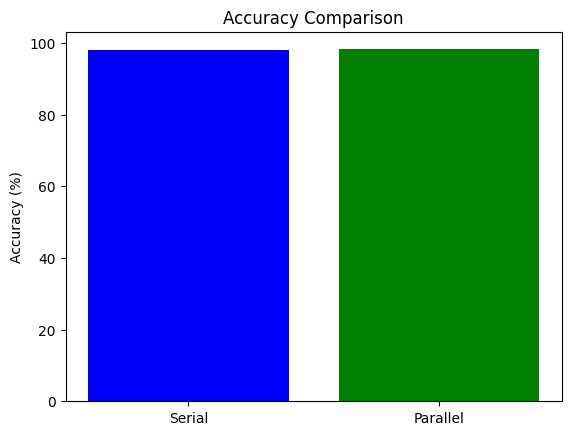

In [11]:
serial_time, serial_acc = train_serial(epochs=5)
parallel_time, parallel_acc = train_parallel(epochs=5)

speedup = serial_time / parallel_time
print(f"Speedup: {speedup:.2f}")
print(f"Serial Accuracy: {serial_acc:.2f}% | Parallel Accuracy: {parallel_acc:.2f}%")

# Accuracy comparison plot
labels = ["Serial", "Parallel"]
accuracies = [serial_acc, parallel_acc]

plt.bar(labels, accuracies, color=['blue','green'])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()
